Download and install PyTorch

In [30]:
!pip3 install torch

Import the required libraries

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler # for validation test

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


**Load and visualise the data**

In [33]:
# Define a transform to convert oahes to tensor and normalize
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,),)])

# Load the training and data sets
train_set = torchvision.datasets.FashionMNIST(
    root = './data'
    ,train=True
    ,download=True
    ,transform=transform
)

test_set = train_set = torchvision.datasets.FashionMNIST(
    root = './data'
    ,train=False
    ,download=True
    ,transform=transform
)

# Prepare validation test
indicies = list(range(len(train_set)))
np.random.shuffle(indicies)
# split since we want 20%
split = int(np.floor(0.2 * len(train_set)))
train_sample = SubsetRandomSampler(indicies[:split])
valid_sample = SubsetRandomSampler(indicies[split:])

# Load the data
train_loader = torch.utils.data.DataLoader(train_set, sampler=train_sample, batch_size=64)
valid_loader = torch.utils.data.DataLoader(train_set, sampler=valid_sample, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

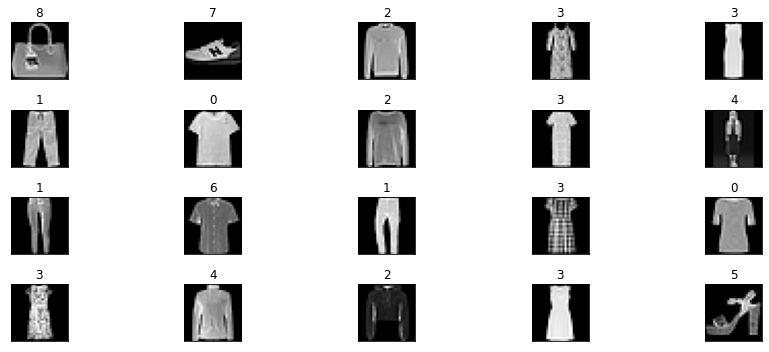

In [34]:
data_iter = iter(train_loader)
print(data_iter)
images, labels = data_iter.next()

fig = plt.figure(figsize=(15,5))
for idx in np.arange(20):
  ax = fig.add_subplot(4,20/4, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(labels[idx].item())
  fig.tight_layout()

In [35]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 120)
    self.fc2 = nn.Linear(120, 120)
    self.fc3 = nn.Linear(120,10)
    #self.fc4 = nn.Linear(64,10)
    #defining the 20% dropout
    self.dropout = nn.Dropout(0.2)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    #x = self.dropout(F.relu(self.fc3(x)))
    #not using dropout on output layer
    x = F.log_softmax(self.fc3(x), dim=1)
    return x   

In [36]:
model = Classifier()
#defining the loss function
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

valid_loss_min = np.Inf #using this high value to make sure the update the weight first time
epochs = 40
steps = 0
model.train() #prep model for training
train_losses, valid_losses = [],[]
for e in range(epochs):
  running_loss =0 
  valid_loss = 0
   # train the model #
  for images, labels in train_loader:

     optimizer.zero_grad()
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     loss.backward()
     optimizer.step()
     running_loss += loss.item()*images.size(0)
  
  for images, labels in valid_loader:
     log_ps = model(images)
     loss = criterion(log_ps, labels)
     valid_loss += loss.item()*images.size(0)

  running_loss = running_loss/len(train_loader.sampler)
  valid_loss =  valid_loss/len(valid_loader.sampler)
  train_losses.append(running_loss)
  valid_losses.append(valid_loss)

  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1,
        running_loss,
        valid_loss
    ))
  if valid_loss <= valid_loss_min:
      print('validation loss decreased({:.6f} -->{:.6f}). Saving Model ...'.format(valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.274577 	Validation Loss: 2.230334
validation loss decreased(inf -->2.230334). Saving Model ...
Epoch: 2 	Training Loss: 2.179617 	Validation Loss: 2.124251
validation loss decreased(2.230334 -->2.124251). Saving Model ...
Epoch: 3 	Training Loss: 2.050778 	Validation Loss: 1.979523
validation loss decreased(2.124251 -->1.979523). Saving Model ...
Epoch: 4 	Training Loss: 1.876274 	Validation Loss: 1.791878
validation loss decreased(1.979523 -->1.791878). Saving Model ...
Epoch: 5 	Training Loss: 1.682915 	Validation Loss: 1.600310
validation loss decreased(1.791878 -->1.600310). Saving Model ...
Epoch: 6 	Training Loss: 1.512262 	Validation Loss: 1.441780
validation loss decreased(1.600310 -->1.441780). Saving Model ...
Epoch: 7 	Training Loss: 1.349643 	Validation Loss: 1.323988
validation loss decreased(1.441780 -->1.323988). Saving Model ...
Epoch: 8 	Training Loss: 1.255435 	Validation Loss: 1.238166
validation loss decreased(1.323988 -->1.238166). Saving

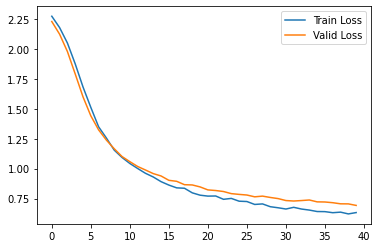

In [37]:
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')

plt.legend()

In [38]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

Calculate the model's accuracy

In [39]:
#track the test loss
test_loss = 0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))


model.eval()
for images, labels in test_loader:
  #forword pass 
  output = model(images)
  #calculate the loss
  loss = criterion(output, labels)
  #update the test loss
  test_loss += loss.item()*images.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  #compare predictions to the true labes
  correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
  #calculate test accuracy for each object class
  for i in range(len(labels)):
    label = labels.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1

#calcaulate and prınt test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%
          (str(i), 100 * class_correct[i]/class_total[i],
           np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A(no training examples)' % classes[i])

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))


Test Loss: 0.610546

Test Accuracy of     0: 79% (792/1000)
Test Accuracy of     1: 93% (933/1000)
Test Accuracy of     2: 61% (616/1000)
Test Accuracy of     3: 85% (859/1000)
Test Accuracy of     4: 72% (725/1000)
Test Accuracy of     5: 85% (852/1000)
Test Accuracy of     6: 29% (296/1000)
Test Accuracy of     7: 80% (804/1000)
Test Accuracy of     8: 91% (919/1000)
Test Accuracy of     9: 93% (938/1000)

Test Accuracy (Overall): 77% (7734/10000)


Load the fashion MNIST labels so they can be compared with the models predictions

In [40]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


Index the predicted value with the (actual value index from the fashion MNIST dataset). Display green if correct, red if not correct.


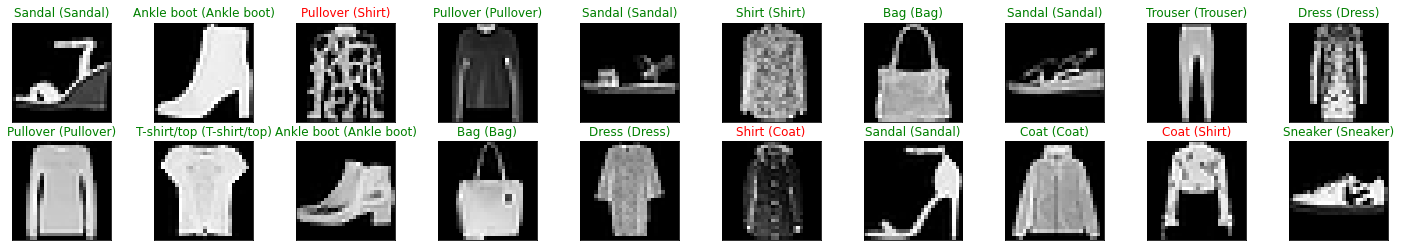

In [41]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(fashion_mnist_labels[preds[idx].item()]), str(fashion_mnist_labels[labels[idx].item()])),
                 color=("green" if preds[idx]==labels[idx] else "red"))
